# Read in the data

In [15]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [16]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [17]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [18]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [19]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [20]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [21]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [22]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [23]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [24]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

%matplotlib inline




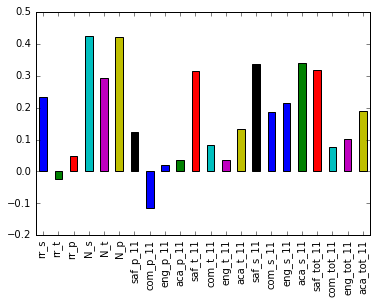

In [27]:
combined.corr()['sat_score'][survey_fields].plot.bar()

# Dictionary
- rr_s - Student Response Rate
- rr_t - Teacher Response Rate
- rr_p - Parent Response Rate
- N_s - Number of student respondents
- N_t - Number of teacher respondents
- N_p - Number of parent respondents
- nr_s - Number of eligible students
- nr_t - Number of eligible teachers
- nr_p - Number of eligible parents
- saf_p_11 - Safety and Respect score based on parent responses
- com_p_11 - Communication score based on parent responses
- eng_p_11 - Engagement score based on parent responses
- aca_p_11 - Academic expectations score based on parent responses
- saf_t_11 - Safety and Respect score based on teacher responses
- com_t_11 - Communication score based on teacher responses
- eng_t_11 - Engagement score based on teacher responses
- aca_t_11 - Academic expectations score based on teacher responses
- saf_s_11 - Safety and Respect score based on student responses
- com_s_11 - Communication score based on student responses
- eng_s_11 - Engagement score based on student responses
- aca_s_11 - Academic expectations score based on student responses
- saf_tot_11 - Safety and Respect total score
- com_tot_11 - Communication total score
- eng_tot_11 - Engagement total score
- aca_tot_11 - Academic Expectations total score

There are strong positive correlations between SAT scores and: 
- Number of student respondents
- Nunmber of teacher respondents
- Number of parent respondents
- Safety and Respect score based on teacher responses
- Safety and Respect score based on student responses
- Academic expectations score based on student responses
- Safety and Respect total score

So, it appears that number of respondents, safety and respect score, and students views of academic expectations all correlate with SAT Scores

I will delve more deeply into safety vs SAT scores.

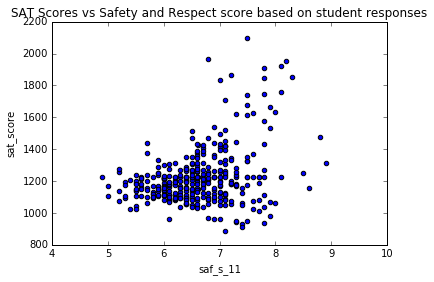

In [30]:

combined.plot.scatter(x='saf_s_11', y='sat_score', 
                      title = "SAT Scores vs Safety and Respect score based on student responses")

You begin to see higher SAT scores whenever safety scores are greater than ~7.5/10. 

In [33]:
avg_ss_dist = combined.groupby('school_dist').agg(numpy.mean)
safety_cats = ['saf_p_11', 'saf_s_11', 'saf_t_11', 'saf_tot_11']

avg_ss_dist = avg_ss_dist[safety_cats]

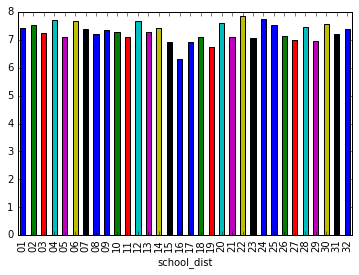

In [47]:
import matplotlib.pyplot as plt

avg_ss_dist['saf_tot_11'].plot.bar()

Average safety scores seem to all around 7, +- 1

I will now investigate correlations between race and SAT score using the columns white_per, asian_per, black_per, and hispanic_per

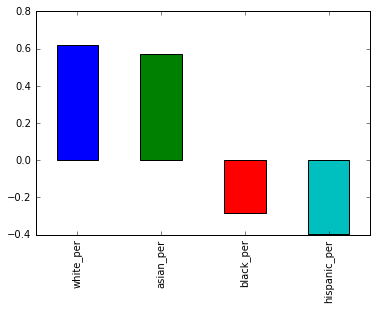

In [49]:
racial_cols = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
combined.corr()['sat_score'][racial_cols].plot.bar()

Schools with a large amount of white and asian students have high scores on the SAT, while schools with a large amount of black and hispanic studetnts have lower scores on the SAT

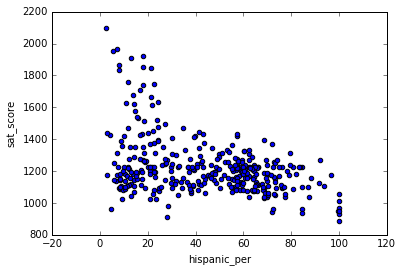

In [64]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

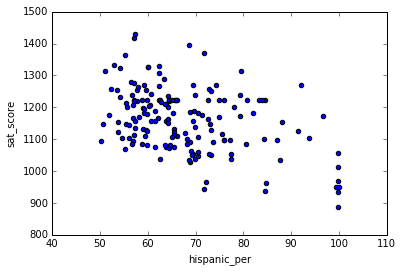

In [66]:
hispanic_low_sat = combined[((combined['hispanic_per'] > 50) & (combined['sat_score'] < 1500))]
hispanic_low_sat.plot.scatter(x='hispanic_per', y='sat_score')

Schools that have close to 100% hispanic students have very low SAT scores. As the percentage of hispanic students increases, the average SAT score decreases.

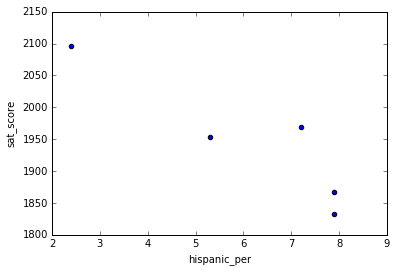

In [67]:
hispanic_high_sat = combined[((combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800))]
hispanic_high_sat.plot.scatter(x='hispanic_per', y='sat_score')

In [69]:
hispanic_high_sat['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

All schools with a low percentage of hispanic students and high SAT scores are either college prep schools or technical schools. Students must have high academic achievements to get into these schools, so you would expect them to have high SAT scores.

I will now plot the correlations between SAT score and male and female percentages

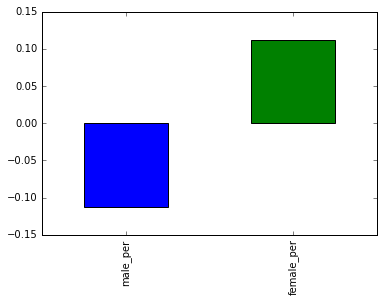

In [70]:
combined.corr()['sat_score'][['male_per', 'female_per']].plot.bar()

A higher female percentage correlates with a higher SAT score, while a higher male percetage correlates with a lower SAT score. However, these are weak correlations.

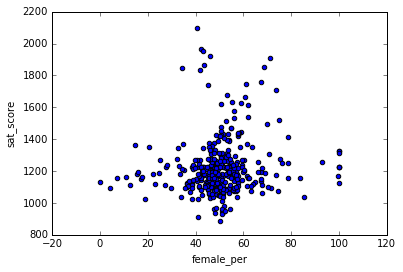

In [76]:
combined.plot.scatter(x='female_per', y='sat_score')

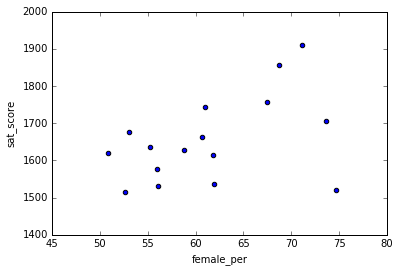

In [78]:
female_high_sat = combined[((combined['female_per'] > 50) & (combined['sat_score'] > 1500))]
female_high_sat.plot.scatter(x='female_per', y='sat_score')

As percentages of females increases, SAT score increases. However, once female percentage = 100%, for female-only schools, average SAT scores return to close to the overall average.

In [79]:
female_high_sat = combined[((combined['female_per'] > 60) & (combined['sat_score'] > 1700))]
female_high_sat['SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

I will now look at the correlation between percentage of students who took an AP exam and SAT scores.

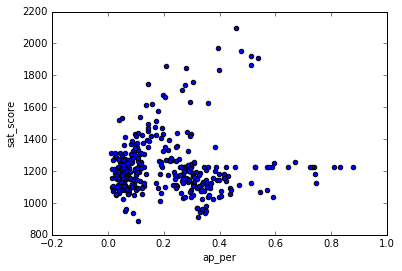

In [80]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']
combined.plot.scatter(x='ap_per', y='sat_score')

There is a positive correlation between the percentage of students who take the AP exam and the SAT score, however there are still many average SAT scores for schools that have a high percentage of students who take an AP exam.